In [ ]:
!nvidia-smi

Wed May 22 14:23:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [ ]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


In [ ]:
MARKET_SQUARE_VIDEO_PATH = "/content/test-video-3.mp4"

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/best.pt')


0: 384x640 2 mans, 1 woman, 8.2ms
Speed: 4.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


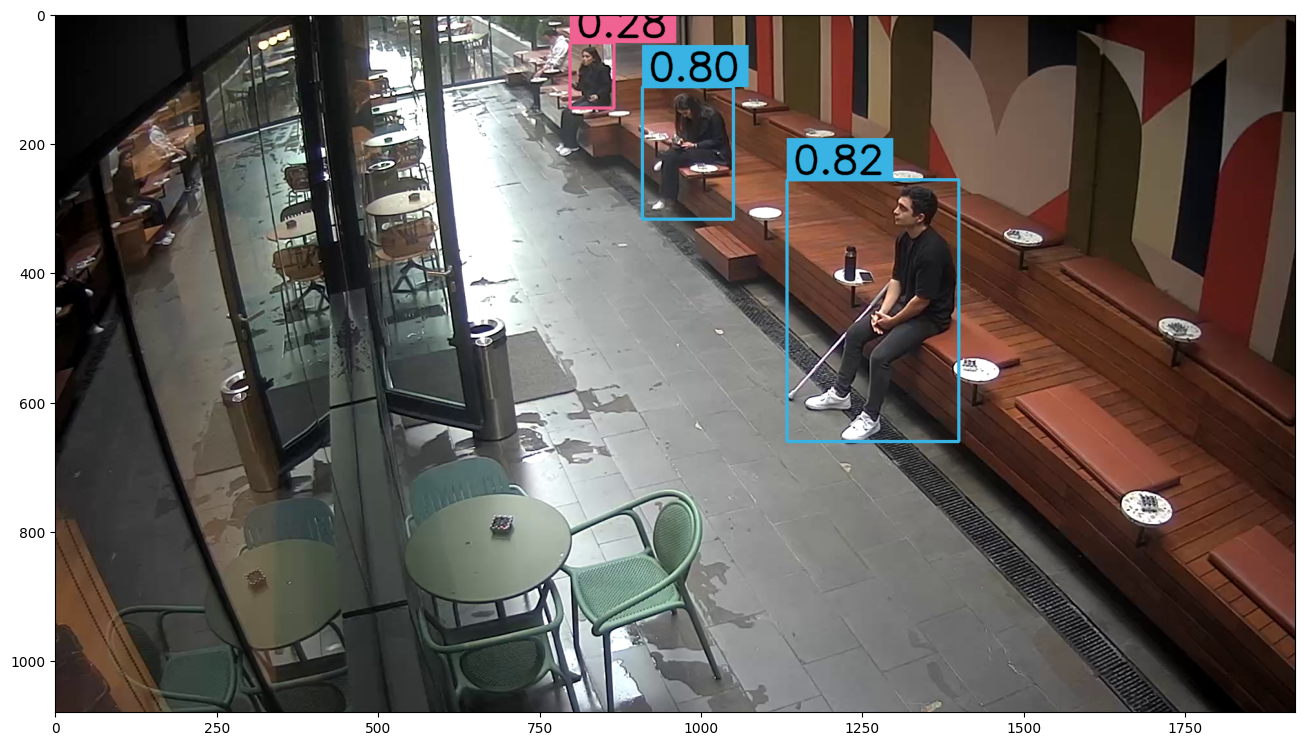

In [ ]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame)[0]
detections = sv.Detections.from_yolov8(results)

#color
color = sv.ColorPalette.from_hex(['#38b3e3', '#f06292'])


# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2, color=color)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [ ]:
sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=60, total_frames=3384)


0: 384x640 2 mans, 1 woman, 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


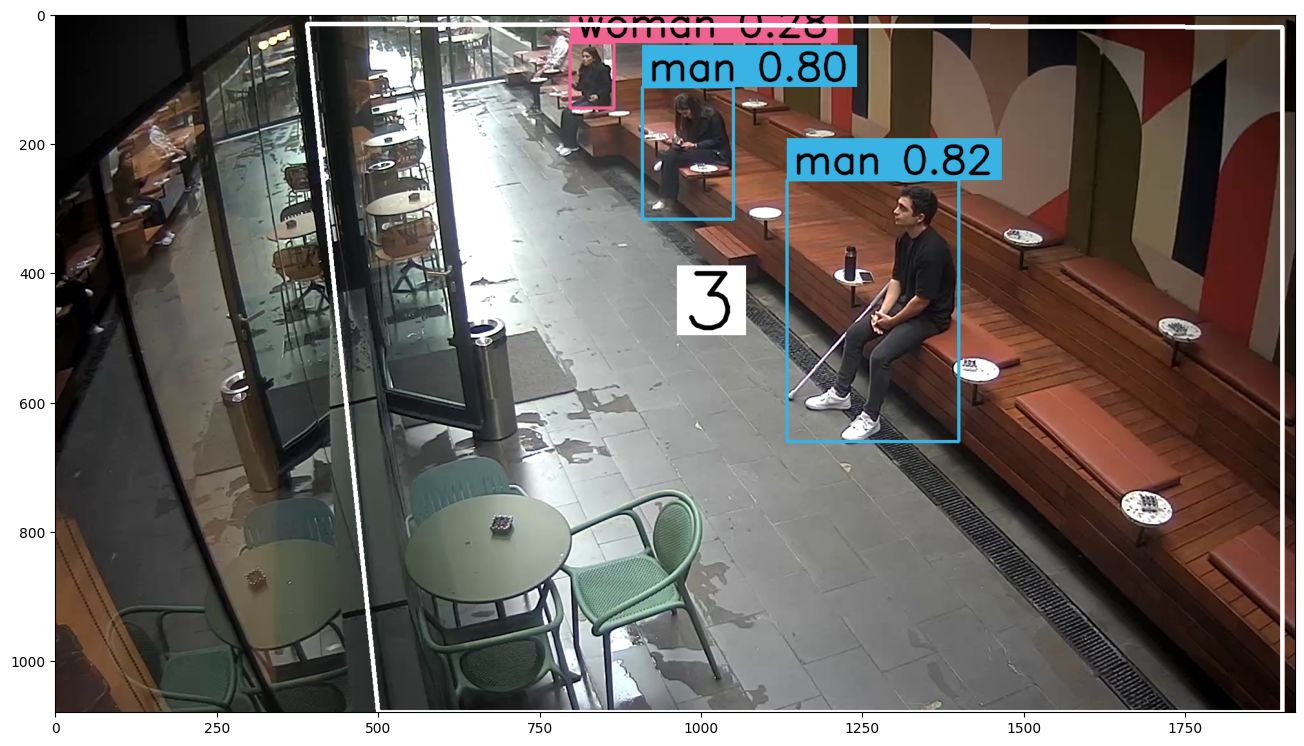

In [ ]:
import numpy as np
import supervision as sv

np.bool = np.bool_

# initiate polygon zone
polygon = np.array([
[390, 17],[500, 1080],[1900, 1080],[1900, 20],[390, 15]
])
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[(detections.class_id == 0) | (detections.class_id == 1)]
zone.trigger(detections=detections)

#color
color = sv.ColorPalette.from_hex(['#38b3e3', '#f06292'])

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2, color=color)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [ ]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
[390, 17],[500, 1080],[1900, 1080],[1900, 20],[390, 15]
])
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model(frame)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[(detections.class_id == 0) | (detections.class_id == 1)]
    zone.trigger(detections=detections)

    #Color
    color = sv.ColorPalette.from_hex(['#38b3e3', '#f06292'])

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2, color=color)
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=MARKET_SQUARE_VIDEO_PATH, target_path=f"{HOME}/result3.mp4", callback=process_frame)

from IPython import display
display.clear_output()

In [ ]:
#chat gpt code
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
[390, 17],[500, 1080],[1900, 1080],[1900, 20],[390, 15]
])
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

#Color
color = sv.ColorPalette.from_hex(['#38b3e3', '#f06292'])

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2, color=color)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

# Counter for female and male detections
female_count = 0
male_count = 0

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    global female_count, male_count

    # Detect objects
    results = model(frame)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[(detections.class_id == 0) | (detections.class_id == 1)]
    zone.trigger(detections=detections)

    # Initialize counts
    female_count = 0
    male_count = 0

    # Dictionary to store the highest confidence class for each box
    highest_confidence_class = {}

    # Find the highest confidence class for each box
    for box, confidence, class_id, _ in detections:
        # Convert box from numpy array to tuple to make it hashable
        box_tuple = tuple(box)
        if box_tuple not in highest_confidence_class or confidence > highest_confidence_class[box_tuple][1]:
            highest_confidence_class[box_tuple] = (class_id, confidence)

    # Count female and male detections
    for class_id, _ in highest_confidence_class.values():
        if class_id == 1:  # Female class
            female_count += 1
        elif class_id == 0:  # Male class
            male_count += 1

    # Annotate the frame
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    # Display female and male counts
    total_count = female_count + male_count
    cv2.putText(frame, f'Total Count: {total_count}', (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Male Count: {male_count}', (20, 140), cv2.FONT_HERSHEY_SIMPLEX, 1, (240, 98, 146), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Female Count: {female_count}', (20, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (56, 179, 227), 2, cv2.LINE_AA)

    return frame

sv.process_video(source_path=MARKET_SQUARE_VIDEO_PATH, target_path=f"{HOME}/test-video-4-colory.mp4", callback=process_frame)

from IPython import display
display.clear_output()
